In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

Идея в том, что в файле *10-million-password-list-top-1000000.txt* находятся отранжированные по частоте использования пароли. Используя этот порядок можно довольно точно предсказать количество использований паролей. Ниже подробности.

Посмотрим на то, какое число паролей из тестовой и из тренировочной выборки совпадает с паролями в файле. И посмотрим на то, как изменяется число использований пароля в зависимости от того, на каком месте он стоит в этом файле.

In [72]:
df_train = pd.DataFrame.from_csv('train.csv')
df_train = df_train[df_train.index.notnull()]
    
df_test = pd.DataFrame.from_csv('Xtest.csv')

df_top1M = pd.read_csv('Common-Credentials/10-million-password-list-top-1000000.txt')

Смотрим на данные.

In [73]:
df_train.head(3)

,Times
Password,
631XniVx2lS5I,2
LEGIT747,1
742364es,1


In [74]:
df_test.head(3)

,Password
Id,
0,ThaisCunha
1,697775113
2,922a16922a


In [75]:
df_top1M.head(3)

,psw
0,123456
1,password
2,12345678


Посмотрим, какую часть файла с 1М самых частых паролей составляют пароли из обучающей и тестовой выборки.

In [8]:
set_train = set(df_train.index.values)
set_test = set(df_test.Password.values)
set_top1M = set(df_top1M.psw.values)

print('train: ', len(set_top1M.intersection(set_train)) / 1e6)
print('test:  ', len(set_top1M.intersection(set_test)) / 1e6)

train:  0.799486
test:   0.200505


Видим, что около 800 тыс. паролей в этом файле есть в обучающей выборке, а около 200 тыс. паролей есть в тестовой. Еще раз: идея в том, что если в исходном файле они расположены по убыванию частотности, и пароли для обучающей и тестовой выборки взяты случайно, то мы можем для 200 тыс паролей довольно точно найти количество их использований, основываясь на количестве использований "соседних" паролей. Ниже приведем еще несколько поясняющих рисунков.

Заполним количества использований у тех паролей, у которых знаем. Сразу же заполняю не самими значениями просмотров, а логарифмом от этой величины. Мне это показалось логичным, судя по метрике соревнования. Да и значения не так резко изменяются от пароля к паролю.

In [76]:
df_top1M['Times'] = df_top1M.psw.apply(lambda x: np.log(df_train.loc[x].Times) if x in set_train else None)
df_top1M.head(10)

,psw,Times
0,123456,10.931194
1,password,NaN
2,12345678,NaN
3,qwerty,9.483188
4,123456789,9.367002
5,12345,9.299998
6,1234,8.769041
7,111111,8.645059
8,1234567,8.475538
9,dragon,8.275631


Значения количества использований для первых 500 паролей в файле. Почти про все пароли нам известны данные.

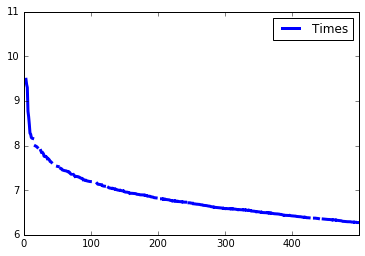

In [77]:
df_top1M[:500].plot(lw=3);

В видимых пропусках данных как раз расположены 200 тысяч паролей, которые есть в тестовой выборке. Для них и надо предсказать количество использований. Ниже еще пара графиков из середины файла с паролями.

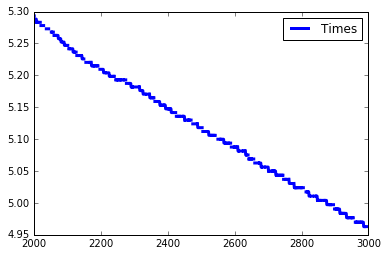

In [78]:
df_top1M[2000:3000].plot(lw=3);

Правда, есть вот такие "шпили", то есть частотность не везде монотонно убывает. Хотя это можно считать небольшой погрешностью.

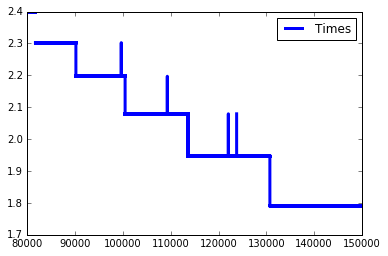

In [45]:
df_top1M[80000:150000].plot(lw=3);

Понятно, что для пропусков мы сможем относительно точно предсказать количество использований.

Для предсказания использовал метод для интерполяции пакета scipy. Аргумент интерполируемой функции - порядковый номер пароля в файле, значение - количество использований. Строчки с неизвестными значениями пропускаем.

In [79]:
from scipy.interpolate import interp1d

x = df_top1M.dropna().index.values
y = df_top1M.dropna().Times.values

f = interp1d(x, y, kind='quadratic')

Проставляем значения. Тут можно сделать быстрее, чем представлено ниже. Нужно заполнять значения только тех полей, которые не заполнены, а не перезаписывать все поля.

In [81]:
%%time
df_top1M['Times'] = [f(i) for i in df_top1M.index.values]

CPU times: user 3min 41s, sys: 899 ms, total: 3min 42s
Wall time: 3min 43s


Смотрим на то, как получилось.

In [84]:
df_top1M.head()

,psw,Times
0,123456,10.931194427688464
1,password,10.263852378817427
2,12345678,9.781183554744441
3,qwerty,9.483187955469509
4,123456789,9.36700218198956


Создадим словарь с предсказанными значениями:

In [88]:
known_d = dict(df_top1M[['psw', 'Times']].values)

Если посмотреть на конец таблицы df_top1M, то все пароли там имеют количество использований = 1. Поэтому пробуем всем паролям, не попавшим в этот файл, проставить значение 1. (Если их нет в топ 1 000 000, то логично, что они использовались всего по разу).

Не забываем, что приближали мы логарифмы. А нужно само количество. Поэтому возводим экспоненту в предсказанную степень.

In [89]:
vals = []

for p in tqdm(df_test['Password'].values):
    if p in known_d:
        vals.append(np.exp(known_d[p]))
    else:
        vals.append(1)
        
df_test['Times'] = vals

100%|██████████| 1037875/1037875 [00:00<00:00, 1509836.38it/s]


Смотрим, как заполнилось.

In [90]:
df_test.head(3)

,Password,Times
Id,,
0,ThaisCunha,1.0
1,697775113,1.0
2,922a16922a,1.0


И составляем submit.

In [91]:
with open('submit.csv', 'w') as fw:
    df_test[['Times']].to_csv(fw)

Сейчас при загрузке на late_submition предсказания показали скор 0.00081.

Видимо при предыдущем сабмите я что-то где-то напутал. А при чистовом оформлении это исправил.

Скорее всего скор можно улучшить, если более аккуратно предсказывать значения для пропущенных паролей в df_top1M. Потому что в этом решении я наугад взял логарифм от количества просмотров и предсказывал его (может, лучше было предсказывать сами значения просмотров). Так же не варьировал параметры интерполирующей функции. Но как видно - и это оказалось неплохим решением.

Комментарии и замечания/исправления привествуются.